In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [4]:
df_email = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding = 'latin-1')
df_email.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df_email_ = df_email[['v1','v2']]
df_email_.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df_email_.isna().sum()

v1    0
v2    0
dtype: int64

In [7]:
df_email_['v1'].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

In [8]:
df_email_['v2']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, GRU, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import string

import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


from transformers import BertTokenizer, TFBertModel

2025-07-13 14:23:12.947061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752416593.162545      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752416593.222353      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
def data_cleaning(text):
    
    # Lower the words in the sentence
    cleaned = text.lower()
    
    # Replace the full stop with a full stop and space
    cleaned = cleaned.replace(".", ". ")

    # Remove the stop words
    tokens = [word for word in cleaned.split() if not word in stop_words]
    
    # Remove the punctuations
    tokens = [tok.translate(str.maketrans(' ', ' ', string.punctuation)) for tok in tokens]
    
    # Joining the tokens back to form the sentence
    cleaned = " ".join(tokens)
    
    # Remove any extra spaces
    cleaned = cleaned.strip()
    
    return cleaned

In [11]:
for index, data in tqdm(df_email_.iterrows(), total=df_email_.shape[0]):
    df_email_.loc[index, 'v2'] = data_cleaning(data['v2'])
# df_email_['v2']

  0%|          | 0/5572 [00:00<?, ?it/s]/tmp/ipykernel_35/3167085814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_email_.loc[index, 'v2'] = data_cleaning(data['v2'])
100%|██████████| 5572/5572 [00:01<00:00, 5037.34it/s]


In [12]:
df_email_['v2']

0       go jurong point crazy  available bugis n great...
1                               ok lar   joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                   u dun say early hor   u c already say
4                  nah think goes usf lives around though
                              ...                        
5567    2nd time tried 2 contact u u å£750 pound prize...
5568                          ì b going esplanade fr home
5569                     pity  mood that so   suggestions
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: v2, Length: 5572, dtype: object

<Axes: >

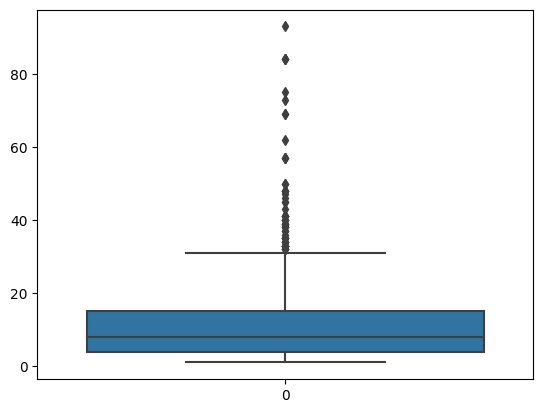

In [13]:
sns.boxplot(df_email_['v2'].str.split(" ").str.len())

In [14]:
max_sentence_len = df_email_['v2'].str.split(" ").str.len().max()
total_classes = df_email_.v1.nunique()

print(f"Maximum sequence length: {max_sentence_len}")
print(f"Total classes: {total_classes}")

Maximum sequence length: 93
Total classes: 2


In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [16]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model

# Load pre-trained BERT
bert = TFBertModel.from_pretrained('bert-base-uncased')
bert.trainable = True  # Fine-tune if needed

class BertLayer(Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert

    def call(self, inputs):
        return self.bert(inputs)[0]  # return last_hidden_state

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

I0000 00:00:1752416651.664915      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752416651.665689      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPre

In [17]:
# Define symbolic inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# Call wrapped BERT inside custom layer
bert_output = BertLayer()({'input_ids': input_ids, 'attention_mask': attention_mask})

# Take CLS token (first token)
cls_token = bert_output[:, 0, :]

In [18]:
Emotion_num = {name:i for i,name in enumerate(df_email_['v1'].unique())}
Emotion_num

{'ham': 0, 'spam': 1}

In [19]:
df_email_['v1_num'] = df_email_['v1'].apply(lambda x: Emotion_num[x])

/tmp/ipykernel_35/3667276022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_email_['v1_num'] = df_email_['v1'].apply(lambda x: Emotion_num[x])


In [20]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_email_['v2'], df_email_['v1_num'], test_size=0.25, random_state=42, stratify=df_email_['v1_num']
)

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(
    list(train_texts), padding='max_length', truncation=True, max_length=128, return_tensors='tf'
)

val_encodings = tokenizer(
    list(val_texts), padding='max_length', truncation=True, max_length=128, return_tensors='tf'
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    train_labels
)).shuffle(100).batch(4)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_encodings['input_ids'],
        'attention_mask': val_encodings['attention_mask']
    },
    val_labels
)).batch(4)

In [23]:
# Add classification head
x = Dense(128, activation='relu')(cls_token)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x) 

# Final model
model = Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 128, 768)       │              0 │ attention_mask[0][0],  │
│                           │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 768)            │              0 │ bert_layer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         98,432 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │            258 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 98,690 (385.51 KB)

 Trainable params: 98,690 (385.51 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
summary = model.fit(train_dataset, validation_data=val_dataset, epochs=3)

Epoch 1/3


I0000 00:00:1752416744.112511     120 service.cc:148] XLA service 0x798c9c039ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752416744.113496     120 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752416744.113517     120 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1752416744.638389     120 assert_op.cc:38] Ignoring Assert operator functional_1/bert_layer_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1752416746.505615     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/1045 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - accuracy: 0.3117 - loss: 0.9313 

I0000 00:00:1752416749.192182     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1043/1045 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8054 - loss: 0.3995

W0000 00:00:1752416784.550827     122 assert_op.cc:38] Ignoring Assert operator functional_1/bert_layer_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert


1045/1045 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8055 - loss: 0.3993

W0000 00:00:1752416792.502648     121 assert_op.cc:38] Ignoring Assert operator functional_1/bert_layer_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1752416807.524850     122 assert_op.cc:38] Ignoring Assert operator functional_1/bert_layer_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert


1045/1045 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - accuracy: 0.8056 - loss: 0.3992 - val_accuracy: 0.9641 - val_loss: 0.1307
Epoch 2/3
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.9665 - loss: 0.1289 - val_accuracy: 0.9742 - val_loss: 0.0872
Epoch 3/3
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 51s 49ms/step - accuracy: 0.9798 - loss: 0.0869 - val_accuracy: 0.9792 - val_loss: 0.0736


In [25]:
predictions = model.predict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask']
})

W0000 00:00:1752417057.366754     121 assert_op.cc:38] Ignoring Assert operator functional_1/bert_layer_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert


43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step

W0000 00:00:1752417083.085511     121 assert_op.cc:38] Ignoring Assert operator functional_1/bert_layer_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert


44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 594ms/step


In [26]:
predicted_classes = np.argmax(predictions, axis=1)

for text, pred in zip(val_texts.to_list(), predicted_classes):
    print(f"Text: {text}")
    print(f"Predicted Class: {pred}")
    print("----------")
    break

Text: left already orchard now
Predicted Class: 0
----------


In [27]:
# y_pred_nb = nb.predict(X_val)
accuracy_score(val_labels, predicted_classes)

0.9791816223977028

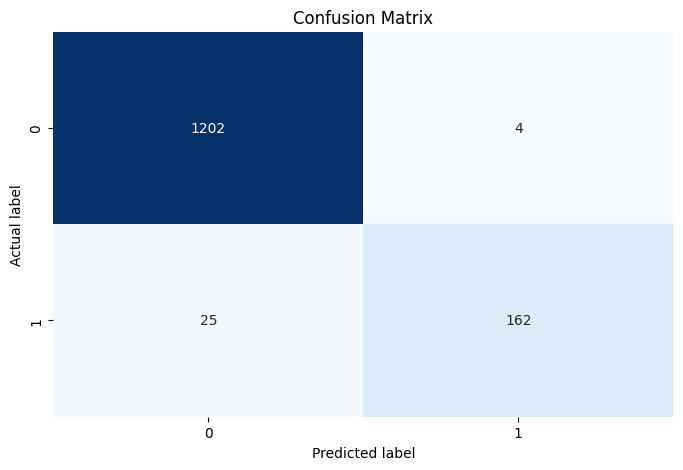

In [28]:
cm = confusion_matrix(val_labels, predicted_classes)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()